убрать ошибку - выбор интерпретатора ctrl + shift + p, same as kernel

In [2]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
PATH = "digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3090 Ti


In [27]:
batch_size = 32
epochs = 50

In [5]:
train_df = pd.read_csv(PATH + "train.csv")
test_df = pd.read_csv(PATH + "test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define class MNIST
I'll define `class MNIST` which was inherited `torch.utils.data.Dataset`.

In [67]:
class MNIST(Dataset):
    def __init__(self, df, train = True, transform = None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        if self.is_train:
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.iloc[:,:].values.astype(np.uint8)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        anchor_img = self.images[index].reshape(28, 28, 1)

        if self.is_train:
            anchor_label = self.labels[index]
            #1 убираем из набора индексов наш якорь | 2 берем индексы лейблы которых совпадают с якорем
            positive_list = self.index[self.index != index][self.labels[self.index != index] == anchor_label]
            positive_index = random.choice(positive_list)
            positive_img = self.images[positive_index].reshape(28, 28, 1)
            negative_list = self.index[self.index != index][self.labels[self.index != index] != anchor_label]
            negative_index = random.choice(negative_list)
            negative_img = self.images[negative_index].reshape(28, 28, 1)
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            return anchor_img, positive_img, negative_img, anchor_label
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [68]:
train_ds = MNIST(
    train_df,
    train=True,
    transform=transforms.Compose([
    transforms.ToTensor()
    ])
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12)

In [70]:
test_ds = MNIST(
    test_df,
    train=False,
    transform=transforms.Compose([
    transforms.ToTensor()
    ])
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=12)

Если расстояние до негатива больше, чем до позитива + margin, то у неас всё сошлось, и будут нулевые лоссы.  
до тех пор будут обновляться веса, поскольку иначе расстояние(позитив + марджин) >> расстояние(неатива) -> loss не нулевой.

In [46]:
class TripletLoss(nn.Module):
    def __init__(self, margin=2) -> None:
        super().__init__()
        self.margin = margin
    
    def calc_euclidian(self, x1, x2):
        return (x1-x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor)-> torch.Tensor:
        distance_positive = self.calc_euclidian(anchor, positive)
        distance_negative = self.calc_euclidian(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [47]:
class ConvBatchNormReLU(nn.Module):
    def __init__(self, input_channels=64, output_channels=64, kernel_size=(3,3), stride=1, pad=1) -> None:
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, pad)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [48]:
class DownSample(nn.Module):
    def __init__(self, kernel_size=2, stride=2) -> None:
        super().__init__()
        self.pooling = nn.MaxPool2d(kernel_size, stride)
    def forward(self, x):
        return self.pooling(x)

In [49]:
class VGG(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        self.conv1 = self.build_block(in_channels, 64)
        self.down1 = DownSample(2,2)
        self.conv2 = self.build_block(64, 128, num_layers=3)
        self.down2 = DownSample(2,2)
        self.conv3 = self.build_block(128, 256, num_layers=3)
        self.adapool = nn.AdaptiveAvgPool2d([1,1])
        self.fc = nn.Linear(256, num_classes)
    
    def build_block(self, input_channels=64, output_channels=64, kernel_size=(3,3), stride=1, pad=1, num_layers=2):
        layers = [ConvBatchNormReLU(input_channels, output_channels, kernel_size, stride, pad)]
        for _ in range(1,num_layers):
            layers.append(ConvBatchNormReLU(output_channels, output_channels, kernel_size, stride, pad))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.down1(x)
        x = self.conv2(x)
        x = self.down2(x)
        x = self.conv3(x)
        x = self.adapool(x)
        x = torch.flatten(x, start_dim=1) # 0dim == batch
        x = self.fc(x)
        return x                


In [50]:
model = VGG(1, 2)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [51]:
model.train()
for epoch in range(epochs):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.3511


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.1657


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.1185


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0953


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0767


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0696


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0545


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0530


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0467


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0395


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.0360


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0320


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0297


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.0286


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0271


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0230


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0200


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0231


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0190


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0180


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0166


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.0182


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0151


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0144


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0168


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0149


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.0131


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.0137


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.0123


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.0119


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0108


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0099


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0120


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0104


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0106


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0092


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0091


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0096


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0077


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0106


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0053


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0094


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0077


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0084


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0061


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0087


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0080


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0070


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0062


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0063


In [76]:
results = []
labels = []

model.eval()
for img, _, _, label in tqdm(train_loader):
    results.append(model(img.to(device)).cpu().detach().numpy() )
    labels.append(label)

train_results = np.concatenate(results)
train_labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/1313 [00:00<?, ?it/s]

(42000, 2)

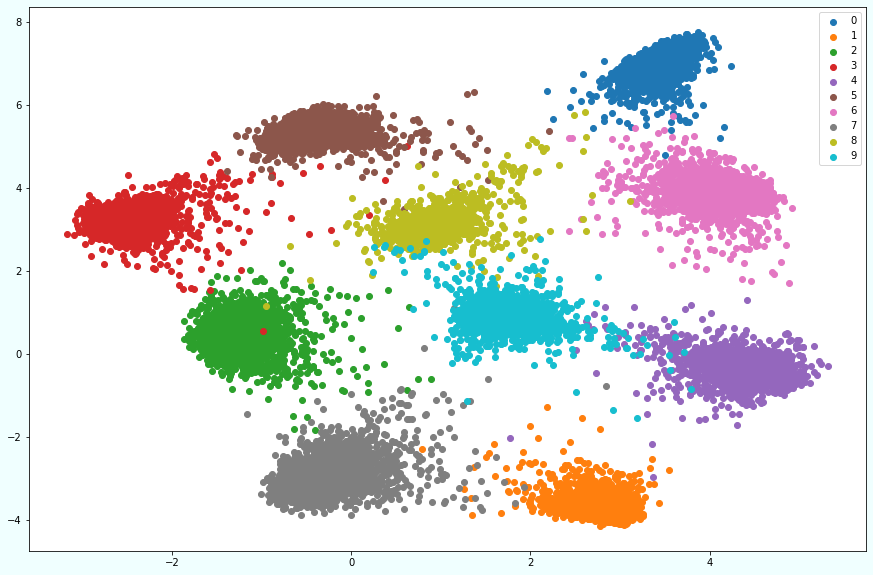

In [78]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(train_labels):
    tmp = train_results[train_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [75]:
results = []
labels = []
for img in tqdm(test_loader):
    results.append(model(img.to(device)).cpu().detach().numpy() )
    labels.append(label)

test_results = np.concatenate(results)
test_labels = np.concatenate(labels)
test_results.shape

  0%|          | 0/875 [00:00<?, ?it/s]

(28000, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


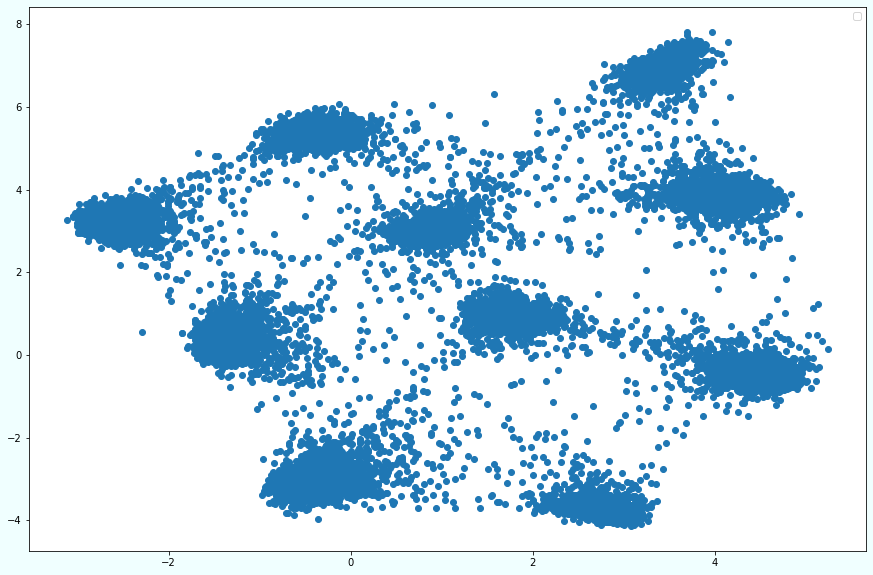

In [82]:
plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1], )

plt.legend()
plt.show()